In [1]:
### fitting the LDS with the neu
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from importlib import reload
from math import radians
def chol(cov):
    """
    cov = a@a.T
    return a
    """
    return torch.linalg.cholesky(cov)

from VAE_project_lib.sym_blk_tridiag_inv import *
from VAE_project_lib.blk_tridiag_chol_tools import *
from VAE_project_lib.LDS import *

In [43]:
#######################################
# DIFINE NON-LINEAR DYNAMICS
#######################################
def dx_dt(x, y):
    return x - x**3/3.0 - y+0
def dy_dt(x, y):
    return 0.5*(1.0*x-2.0*y)

#######################################
# PARAMETER INITIALIZATION
#######################################
xdim=100
zdim=2
angle = radians(5)
rm = [[math.cos(angle), -math.sin(angle)],
      [math.sin(angle), math.cos(angle)]]

non_linear_teacher = dynamics(dx_dt,dy_dt)
noise_amp=0.05
TeacherGenerativeParams = {
    'mu1': torch.tensor([0.0,0.0]), #need to optimize
    'Q1chol': 2*torch.eye(zdim), #optimize chol(Q1)
    'A': torch.tensor(rm), # 
    'Qchol': noise_amp*torch.eye(zdim), #optimize chol(Q)
    'NN': nn.Sequential(nn.Linear(zdim, 25),nn.Tanh(),nn.Linear(25,xdim),Exp()),
#     'NN': nn.Sequential(nn.Linear(zdim, xdim),Exp()),
    'Rchol':torch.diag(noise_amp*torch.eye(xdim)),
    'ProbFunc': None, 
    'ProbPara': None,
    'zdim':zdim, 
    'xdim': xdim,
    "nN":non_linear_teacher
}

deep =  deepnet(zdim,[10,8,5,5,5],zdim)
non_linear_student = dynamics_student(deep)
StudentGenerativeParams= {
    'mu1': torch.randn(zdim), #need to optimize
    'Q1chol': torch.eye(zdim), #optimize chol(Q1)
    'A': torch.randn(zdim,zdim), #need to optimize 
    'Qchol': torch.eye(zdim), #optimize chol(Q)
    'NN': nn.Sequential(nn.Linear(zdim, 70),nn.Tanh(),nn.Linear(70,xdim),Exp()),
#     'NN': nn.Sequential(nn.Linear(zdim, xdim),Exp()),
    'Rchol':torch.diag(torch.eye(xdim)),
    'ProbFunc': None, 
    'ProbPara': None,
    'zdim':zdim, 
    'xdim': xdim,
    "nN":non_linear_student
                    }


StudentRecognitionParams = {
    "NN_Mu": NN_5l(xdim,[200,200,200,200,60],zdim),
    "NN_Lambda": NN_5l(xdim,[200,200,200,200,60],zdim*zdim),
    "NN_LambdaX": NN_5l(xdim*2,[200,200,200,200,60],zdim*zdim,offdiag=True),
    "xdim":xdim,
    "zdim":zdim
}


StudentGenerativeParams1= {
    'mu1': torch.randn(zdim), #need to optimize
    'Q1chol': torch.eye(zdim), #optimize chol(Q1)
    'A': torch.randn(zdim,zdim), #need to optimize 
    'Qchol': torch.eye(zdim), #optimize chol(Q)
    'NN': nn.Sequential(nn.Linear(zdim, 70),nn.Tanh(),nn.Linear(70,xdim),Exp()),
#     'NN': nn.Sequential(nn.Linear(zdim, xdim),Exp()),
    'Rchol':torch.diag(torch.eye(xdim)),
    'ProbFunc': None, 
    'ProbPara': None,
    'zdim':zdim, 
    'xdim': xdim,
    "nN":non_linear_student
                    }


StudentRecognitionParams1 = {
    "NN_Mu": NN_5l(xdim,[200,200,200,200,60],zdim),
    "NN_Lambda": NN_5l(xdim,[200,200,200,200,60],zdim*zdim),
    "NN_LambdaX": NN_5l(xdim*2,[200,200,200,200,60],zdim*zdim,offdiag=True),
    "xdim":xdim,
    "zdim":zdim
}

#####################################
# GENERATING TRAINING DATA FROM TEACHER
#####################################
T = 200
trail_num=1500
datasx = torch.zeros(trail_num,T,xdim)
datasz = torch.zeros(trail_num,T,zdim)

teacherLDS = nLDS(TeacherGenerativeParams)
for i in range(trail_num):
    x,z = teacherLDS.xsample(T,returnz=True)
    datasx[i] = x
    datasz[i] = z


In [40]:
##################
# non-linear latent dynamics
##################
myvae = VAE(StudentGenerativeParams,StudentRecognitionParams,nLDS,inverse_LDS,beta=1)


In [44]:
##################
# linear latent dynamics
##################
myvae_linear = VAE(StudentGenerativeParams1,StudentRecognitionParams1,LDS,inverse_LDS,beta=1)

In [41]:
#######################################
# TRAINING non-linear VAE
#######################################

optimizer = torch.optim.Adam(myvae.parameters(), lr=0.001)
train_vae(myvae, datasx, optimizer, device="cpu", epochs=15)

Epoch [1/15], Loss: -28294.9859
Epoch [2/15], Loss: -46662.4357
Epoch [3/15], Loss: -47535.2321
Epoch [4/15], Loss: -47667.1636
Epoch [5/15], Loss: -47913.4390
Epoch [6/15], Loss: -47658.7226
Epoch [7/15], Loss: -48120.2852
Epoch [8/15], Loss: -48061.1393
Epoch [9/15], Loss: -48119.5074
Epoch [10/15], Loss: -48292.8993


KeyboardInterrupt: 

In [45]:
#######################################
# TRAINING linear VAE
#######################################

optimizer = torch.optim.Adam(myvae_linear.parameters(), lr=0.001)
train_vae(myvae_linear, datasx, optimizer, device="cpu", epochs=15)

Epoch [1/15], Loss: -24795.8986
Epoch [2/15], Loss: -45510.6735
Epoch [3/15], Loss: -46038.0975
Epoch [4/15], Loss: -46294.1614
Epoch [5/15], Loss: -47127.0083
Epoch [6/15], Loss: -47241.9768
Epoch [7/15], Loss: -47455.7240
Epoch [8/15], Loss: -47687.3026
Epoch [9/15], Loss: -47956.0024
Epoch [10/15], Loss: -48208.2036
Epoch [11/15], Loss: -47855.1109
Epoch [12/15], Loss: -48121.3118
Epoch [13/15], Loss: -48183.4929
Epoch [14/15], Loss: -48290.0300
Epoch [15/15], Loss: -48342.3084


tensor([[ 0.8148, -0.2627],
        [-0.5659, -0.9280],
        [-0.0447, -0.1236]])


Text(0.5, 0, 'time steps')

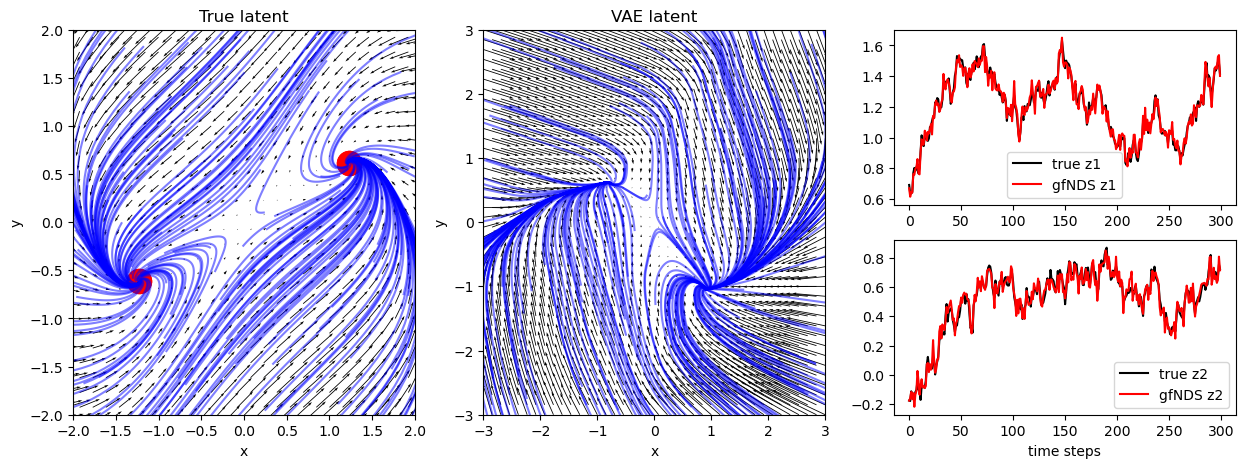

In [42]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(2, 3)  
ax1 = fig.add_subplot(gs[:, 0])  # 第一列占据所有行
ax2 = fig.add_subplot(gs[:, 1])  # 第二列占据所有行
ax3 = fig.add_subplot(gs[0, 2])  # 第三列的第一行
ax4 = fig.add_subplot(gs[1, 2])  # 第三列的第二行
ax=[ax1,ax2,ax3,ax4]
#######################################
#VISUALIZE NON-LINEAR DYNAMICS in TEACHER
#######################################
stable_points = find_stable_points(dx_dt, dy_dt)
x = np.linspace(-3, 3, 40)
y = np.linspace(-3, 3, 40)
X, Y = np.meshgrid(x, y)
origin_shape = X.shape

U = dx_dt(X, Y)
V = dy_dt(X, Y)

ax[0].quiver(X, Y, U, V, scale=40) 
for sp in stable_points:
    ax[0].scatter(sp[0],sp[1],s=300,color="r")
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ll = dynamics(dx_dt,dy_dt)
for i in range(200):
    ip = 6*(np.random.rand(2)-0.5)
    tt = trajectory(ip,ll,100)
    ax[0].plot(tt[:,0],tt[:,1],color="b",alpha=0.5)
ax[0].set_xlim(-2,2)
ax[0].set_ylim(-2,2)
ax[0].set_title("True latent")
#######################################
#VISUALIZE NON-LINEAR DYNAMICS in STUDENT
#######################################
XY = torch.tensor(np.concatenate([X.reshape(-1,1),Y.reshape(-1,1)],axis=1)).float()
with torch.no_grad():
    dXY = deep(XY)
dXY = dXY.detach().numpy()
dX = dXY[:,0].reshape(origin_shape)
dY = dXY[:,1].reshape(origin_shape)

ax[1].quiver(X, Y, dX, dY, scale=40) 
# for sp in stable_points:
#     plt.scatter(sp[0],sp[1],s=300,color="r")
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')


for i in range(200):
    ip = 10*(np.random.rand(2)-0.5)
    tt = trajectory_network(ip,deep,200)
    ax[1].plot(tt[:,0],tt[:,1],color="b",alpha=0.5)
ax[1].set_xlim(-3,3)
ax[1].set_ylim(-3,3)
ax[1].set_title("VAE latent")

#############################################
# the inferred latent trajectory
#############################################
x,z = teacherLDS.xsample(300,returnz=True)
vae_z=myvae.Recognition.encode(x)
#     vae_z = myvae.Recognition.mu(x).detach()
prj_m = z_projection_single(vae_z,z)
print(prj_m)
vae_z = proj(vae_z,prj_m)
true_z = z

ax[2].plot(true_z[:,0],color="k",alpha=1,label="true z1")
ax[2].plot(vae_z[:,0],color="r",alpha=1,label="gfNDS z1")
ax[3].plot(true_z[:,1],color="k",alpha=1,label="true z2")
ax[3].plot(vae_z[:,1],color="r",alpha=1,label="gfNDS z2")
ax[2].legend()
ax[3].legend()
ax[3].set_xlabel("time steps")

In [ ]:
#Demonstrate the latent dynamic of linear VAE, to be finished in the future...